In [5]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

import os 

import hls4ml
import numpy as np
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt

from utils.config import print_dict


In [6]:
# Load data 
data_dir = '../data/new-raw-data-all/'

X_train_val = np.load(os.path.join(data_dir, 'X_train.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
X_test = np.ascontiguousarray(X_test)
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

X_train_val.shape

(909000, 1540)

In [8]:
# Load checkpoints  
save_dir = '../checkpoints/ensemble/'
model1_file = os.path.join(save_dir, 'modelv2_1.h5')
model2_file = os.path.join(save_dir, 'modelv2_2.h5')

co = {} 
_add_supported_quantized_objects(co)
model1 = load_model(model1_file, custom_objects=co, compile=False)
model2 = load_model(model2_file, custom_objects=co, compile=False)

t = 2 # [1, 2]
slice_width = int(1540 / 2)  # input_size / slices 
y_pred = model1.predict(X_test[:,slice_width*(t-1):slice_width*t])
print(model1.summary()) 

3157/3157 [==============================] - 3s 828us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QDense)             (None, 3)                 2313      
                                                                 
 batchnorm1 (BatchNormalizat  (None, 3)                12        
 ion)                                                            
                                                                 
Total params: 2,325
Trainable params: 2,319
Non-trainable params: 6
_________________________________________________________________
None


In [10]:
# Compute the output for slice 1 & 2 
# used for model2 HLS configutation 

t = 1 # [1, 2]
y_pred_m1_s1 = model1.predict(X_test[:,slice_width*(t-1):slice_width*t])

t = 2 # [1, 2]
y_pred_m1_s2 = model1.predict(X_test[:,slice_width*(t-1):slice_width*t])

3157/3157 [==============================] - 3s 922us/step


In [11]:
hls4ml_dir = '../hls4ml_prjs/ensemle/'

np.savetxt(os.path.join(hls4ml_dir, 'tb_input_features.dat'), X_test, fmt='%i')

# Save input in "slices"
t = 1; input_slice1 = X_test[:,slice_width*(t-1):slice_width*t]
np.savetxt(os.path.join(hls4ml_dir, 'tb_input_features_s1.dat'), input_slice1, fmt='%i')
t = 2; input_slice2 = X_test[:,slice_width*(t-1):slice_width*t]
np.savetxt(os.path.join(hls4ml_dir,'tb_input_features_s2.dat'), input_slice1, fmt='%i')

# Save output of Model#1 for each slice 
np.savetxt(os.path.join(hls4ml_dir,'tb_output_predictions_s1.dat'), y_pred_m1_s1, fmt='%.10f')
np.savetxt(os.path.join(hls4ml_dir,'tb_output_predictions_s2.dat'), y_pred_m1_s2, fmt='%.10f')

## HLS project for Model1

In [12]:
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'
HLSConfig['Model']['ReuseFactor'] = 1

HLSConfig['LayerName'] = {}
for layer in ['layer1_input', 'layer1', 'layer1_linear', 'batchnorm1']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

HLSConfig['LayerName']['layer1_input']['Precision'] = 'ap_fixed<14,14>'

### LAYER 1 ###
HLSConfig['LayerName']['layer1']['Precision']['result'] = 'ap_fixed<20,17>'
HLSConfig['LayerName']['layer1']['accum_t'] = 'ap_fixed<20,17>'
HLSConfig['LayerName']['layer1_linear']['Precision']['result'] = 'ap_fixed<20,17>'

### BATCHNORM 1 ###
HLSConfig['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<16,4>'
HLSConfig['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<16,4>'
HLSConfig['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<16,4>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  layer1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  layer1
    Precision
      result:        ap_fixed<20,17>
    Trace:           True
    accum_t:         ap_fixed<20,17>
  layer1_linear
    Precision
      result:        ap_fixed<20,17>
    Trace:           True
  batchnorm1
    Precision
      scale:         ap_fixed<16,4>
      bias:          ap_fixed<16,4>
      result:        ap_fixed<16,4>
    Trace:           True


In [14]:
OutputDir = '../hls4ml_prjs/ensemle/model1'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 5
HLSFig = OutputDir+'/model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model1,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    backend='VivadoAccelerator',
)

print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 770]], output shape: [None, 770]
Layer name: layer1, layer type: QDense, input shapes: [[None, 770]], output shape: [None, 3]
Layer name: batchnorm1, layer type: BatchNormalization, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Creating hls4ml project directory ../hls4ml_prjs/ensemle/model1
Writing HLS project


Done


In [15]:
# Get traces by slice 
t = 1
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test[:,slice_width*(t-1):slice_width*t])) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model1, X_test[:,slice_width*(t-1):slice_width*t]) 

Recompiling myproject with tracing
Writing HLS project


Done


In [18]:
acc_score = accuracy_score(np.argmax(y_pred[:1000], axis=1), np.argmax(hls_trace['batchnorm1'][:1000], axis=1))
print('Accuracy score (first 1000):', acc_score)

Accuracy score (first 1000): 0.486


layer1 		 18.172064
hls/keras min: -3188.625/-3171.8125
hls/keras max: 5118.375/5139.328125
batchnorm1 		 0.07990649
hls/keras min: -4.160888671875/-4.691735744476318
hls/keras max: 4.20703125/4.867698669433594


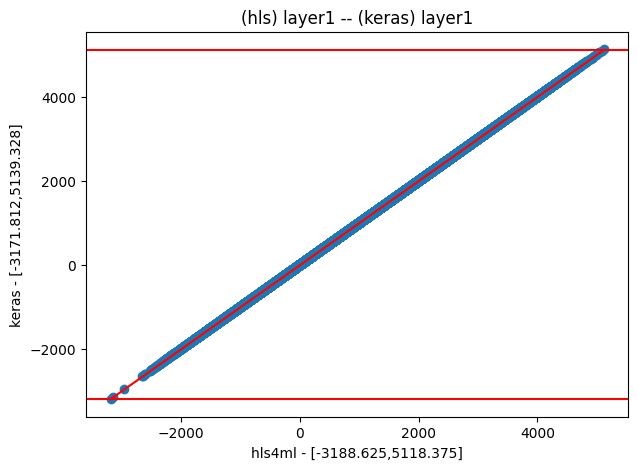

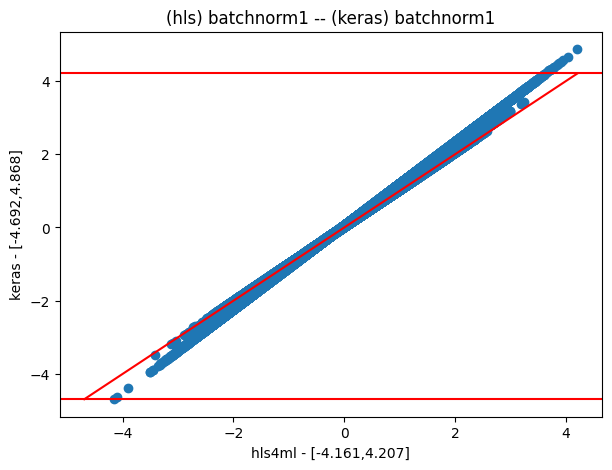

In [20]:
layers = ['layer1', 'batchnorm1']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')
        # plt.plot([min_x, max_x], [min_x, max_x], c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')
        # plt.show()
        
        # plt.savefig(f'../results/{idx}_(hls){layer} -- (keras){layer}.png')
        # plt.close()

    except Exception as e:
        print(e)


## HLS project for Model #2

In [30]:
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,4>'
HLSConfig['Model']['ReuseFactor'] = 1

HLSConfig['LayerName'] = {}
for layer in ['layer1_input', 'layer1', 'layer1_linear']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

HLSConfig['LayerName']['layer1_input']['Precision'] = 'ap_fixed<16,6>'

### LAYER 1 ###
HLSConfig['LayerName']['layer1']['Precision']['result'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1']['accum_t'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1_linear']['Precision']['result'] = 'ap_fixed<16,10>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,4>
  ReuseFactor:       1
LayerName
  layer1_input
    Precision:       ap_fixed<16,6>
    Trace:           True
  layer1
    Precision
      result:        ap_fixed<16,10>
    Trace:           True
    accum_t:         ap_fixed<16,10>
  layer1_linear
    Precision
      result:        ap_fixed<16,10>
    Trace:           True


In [31]:
OutputDir = '../hls4ml_prjs/ensemle/model2'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 5
HLSFig = OutputDir+'model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model2,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    backend='VivadoAccelerator',
)

print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 6]], output shape: [None, 6]
Layer name: layer1, layer type: QDense, input shapes: [[None, 6]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory ../hls4ml_prjs/ensemle/model2
Writing HLS project


Done


In [32]:
# Output of Model#1 is fed to Model#2
X_test_m2 = np.concatenate([y_pred_m1_s1, y_pred_m1_s2], 1)

y_hls = hls_model.predict(X_test_m2) 
_, hls_trace = hls_model.trace(np.ascontiguousarray(np.concatenate([y_pred_m1_s1, y_pred_m1_s2], 1))) 

# Get predictions from keras model 
y_pred = model2.predict(X_test_m2)

Recompiling myproject with tracing
Writing HLS project


Done
3157/3157 [==============================] - 2s 545us/step


In [33]:
np.savetxt('tb_output_predictions.dat', y_pred, fmt='%.10f')

In [34]:
print('First 10 output (Slice #1) from Keras')
print(y_pred[:10])
print('========================')
print('First 10 output (Slice #1) from HLS')
print(y_hls[:10])

First 10 output (Slice #1) from Keras
[[-1.2730651   2.8971784 ]
 [ 0.12849537  1.4764111 ]
 [-0.5888995   2.6245382 ]
 [-1.5117546   1.8628656 ]
 [-1.3464706   2.08262   ]
 [-1.0475997   1.126527  ]
 [-0.33013207  2.7045646 ]
 [-0.19120923  0.01696428]
 [-0.40738404  2.0801795 ]
 [-0.9486349   2.0036182 ]]
First 10 output (Slice #1) from HLS
[[-1.3125    2.828125]
 [ 0.078125  1.40625 ]
 [-0.625     2.578125]
 [-1.546875  1.78125 ]
 [-1.40625   2.03125 ]
 [-1.09375   1.0625  ]
 [-0.359375  2.640625]
 [-0.234375 -0.03125 ]
 [-0.4375    2.03125 ]
 [-0.984375  1.953125]]


In [35]:
acc_score = accuracy_score(np.argmax(y_pred[:1000], axis=1), np.argmax(y_hls[:1000], axis=1))
print('Accuracy score (first 1000):', acc_score)

keras_trace = hls4ml.model.profiling.get_ymodel_keras(model2, X_test_m2) 

Accuracy score (first 1000): 0.999
Processing layer1 in Keras model...
3157/3157 [==============================] - 2s 549us/step
Done taking outputs for Keras model.


layer1 		 0.051245116
hls/keras min: -5.53125/-5.464135646820068
hls/keras max: 4.890625/4.939702987670898


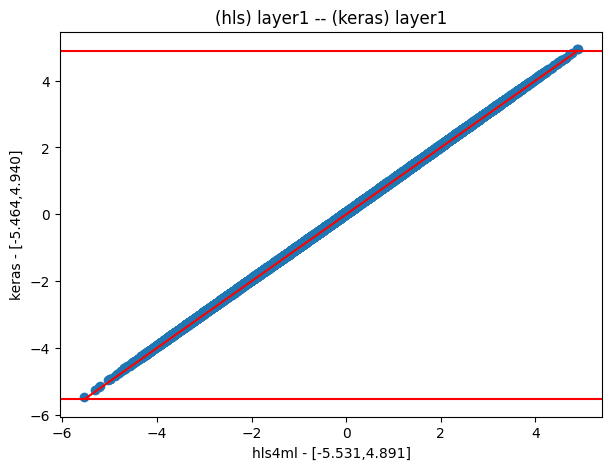

In [36]:
layers = ['layer1']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')

    except Exception as e:
        print(e)


1. Copy model1 > wrapper
2. Encapsulate wrapper with namespace::model1
3. Copy defines, append  _M2
4. Copy parameters, but comment out weight header files (update defines with _M2 )
5. Copy weight files, update ifndef and offset file and variable names by 90
6. Copy myproject, update defines with _M2 and change file names (numbers offset by 90)
7. Update myproject_axi.h and .cpp files (will vary depending on number of copies, model#1 output shape, etc)